Copyright 2019 Google LLC.
SPDX-License-Identifier: Apache-2.0

**Notebook Version** - 1.0.0

# Analyzing Census Data with Data Commons

Datacommons is intended for various data science tasks. This tutorial introduces the datacommons knowledge graph and discusses two tools to help integrate its data into your data science projects: (1) the [datacommons browser](https://browser.datacommons.org/) and (2) the [Python Client API](https://github.com/google/datacommons). Before getting started, we will need to install the Python API package.   


In [0]:
# Install datacommons
!pip install --upgrade --quiet git+https://github.com/datacommonsorg/api-python.git@stable-1.x

## What is Data Commons?

Data Commons is an open knowledge graph of structured data. It contains statements about real world objects such as

* [Santa Clara County](https://browser.datacommons.org/kg?dcid=geoId/06085) is contained in the [State of California](https://browser.datacommons.org/kg?dcid=geoId/06)
* The latitude of [Berkeley, CA](https://browser.datacommons.org/kg?dcid=geoId/0606000) is 37.8703
* The [population of all persons in Maryland ](https://browser.datacommons.org/kg?dcid=dc/o/6w1c9qk7hxjch)has a total count of 5,996,080.

In the graph, [*entities*](https://en.wikipedia.org/wiki/Entity) like [Santa Clara County](https://browser.datacommons.org/kg?dcid=geoId/06085) are represented by nodes. Every node has a type corresponding to what the node represents. For example, [California](https://browser.datacommons.org/kg?dcid=geoId/06) is a [State](https://schema.org/State). *Relations* between entities are represented by edges between these nodes. For example, the statement "Santa Clara County is contained in the State of California" is represented in the graph as two nodes: "Santa Clara County" and "California" with an edge labeled "[containedInPlace](https://schema.org/containedInPlace)" pointing from Santa Clara to California. Data Commons closely follows the [Schema.org data model](https://schema.org/docs/datamodel.html) and leverages schema.org schema to provide a common set of types and properties.

## Data Commons Browser

The [Data Commons browser](https://browser.datacommons.org/) provides a way to explore the data in a human-readable format. It is the best way to explore what is in Data Commons. Searching in the browser for an entity like [Mountain View](https://browser.datacommons.org/kg?dcid=geoId/0649670), takes you to a page about the entity, including properties like [containedInPlace](https://browser.datacommons.org/kg?dcid=containedInPlace) and [timezone](https://browser.datacommons.org/kg?dcid=timezone).

An important property for all entities is the **`dcid`**. The `dcid` (DataCommons identifier) is a unique identifier assigned to each entity in the knowledge graph. With this identifier, you will be able to search for and query information on the given entity in ways that we will discuss later. The `dcid` is listed at the top of the page next to "About: " and also in the list of properties. 

## Python API

The [Python Client API](https://github.com/datacommonsorg/api-python) provides functions for users to extract structured information from Data Commons programmatically and view them in different formats such as Python `dict`'s and [Pandas](https://pandas.pydata.org/) DataFrames. DataFrames allow access to all the data processing, analytical and visualization tools provided by packages such as Pandas, NumPy, SciPy, and Matplotlib.

Every notebook begins by loading the dataCommons client as follows:


In [0]:
# Import Data Commons
import datacommons as dc

# Import other required libraries
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd

import json

We will also need to provide an API key to access the Data Commons Python Client API. This notebook is setup to read from a `json` file stored at `key_path` in your Google Drive. This text file should have one line:

 ```
{
  "dc_api_key": "YOUR-API-KEY"
}
 ```
 
 If you want to make a copy of this notebook, make sure to replace `key_path` with the path to a file containing your API key. For more detail, visit the [Creating an API Key](https://datacommons.readthedocs.io/en/latest/started.html#creating-an-api-key) page of the Python Client API documentation.



In [0]:
# The key is stored in a secret file. To use this notebook, you will need to 
# make a copy and point this line to the file containing the key in your drive!
from google.colab import drive

# Mount the Drive
drive.mount('/content/drive', force_remount=True)

# REPLACE THIS with the path to your key.
key_path = '/content/drive/My Drive/DataCommons/secret.json'

# Read the key in and provide it to the Data Commons API
with open(key_path, 'r') as f:
  secrets = json.load(f)
  dc.set_api_key(secrets['dc_api_key'])

## Example: Median Age vs Population by State
For this exercise, we will be comparing the median ages and population count for US states, counties, and cities. First, let's lookup the dcid for the [United States](https://browser.datacommons.org/kg?dcid=country/USA)'. 

Note that "Country" defines the Data Commons type, and "country" is the name we assign to this column. 


### Using `get_places_in` to Query Administrative Areas

The Client API defines a number of convenience functions for building Pandas dataframes with information in the datacommons graph. We will be using **`get_places_in`** which requires three arguments:

- `dcids` - A list or `pandas.Series` of dcids identifying administrative areas that we wish to get containing places for.
- `place_type` - The type of the administrative area that we wish to query for.

In the datacommons knowledge graph, the 'containedInPlace' property relates a administrative area types to its containing administrative area type. Concretely, every 'state' node has a directed edge to a 'country' node where the name of this edge is 'containedInPlace'. To confirm this, you can check the browser page for '[United States](https://browser.datacommons.org/kg?dcid=country/USA)'. The same also goes for 'county' to 'state' nodes and 'city' to 'county'.

When we provide a `pandas.Series` to `get_places_in`, we get back a `pandas.Series` with the all places contained in the Administrative Areas identified by the given series of dcids.

In [0]:
# Create a three DataFrames with the dcid of the USA storing state, county and 
# city data respectively.
state = pd.DataFrame({'country': ['country/USA']})
county = pd.DataFrame({'country': ['country/USA']})
city = pd.DataFrame({'country': ['country/USA']})

# Get all states, counties, and cities within the United States
state['state'] = dc.get_places_in(state['country'], 'State')
county['county'] = dc.get_places_in(county['country'], 'County')
city['city'] = dc.get_places_in(county['country'], 'City')

Let's see what each table has.

In [0]:
# Display the state data
state.head(5)

,country,state
0,country/USA,"[geoId/01, geoId/02, geoId/04, geoId/05, geoId..."


In [0]:
# Display the county data
county.head(5)

,country,county
0,country/USA,"[geoId/01001, geoId/01003, geoId/01005, geoId/..."


In [0]:
# Display the city data
city.head(5)

,country,city
0,country/USA,"[geoId/0100100, geoId/0100124, geoId/0100460, ..."


Notice that each table only has one row where the column that we just added has a list of items. This is because there are many States, Counties, Cities in the United States! We can expand this list out by calling **`flatten_frame`** or **`pandas.explode`** if using a version of Pandas more recent than 0.25.

In [0]:
# Unroll the frames
state = dc.flatten_frame(state)
county = dc.flatten_frame(county)
city = dc.flatten_frame(city)

# Display the first 5 rows of this table.
state.head(5)

,country,state
0,country/USA,geoId/01
1,country/USA,geoId/02
2,country/USA,geoId/04
3,country/USA,geoId/05
4,country/USA,geoId/06


Unfortunately, dcids aren't very readable. Let's call **`get_property_values`** to include a column with the name for each County. This function call returns a column of names associated with each item in the calling column of dcids. Here 'name' specifies the property/edge of interest, and each of `data['state']`, `data['county']`, and `data['city']` contain dcids identifying source nodes for this relation.

**Note** - This query may take a minute!

In [0]:
# Get all state, county, and city names
state['state_name'] = dc.get_property_values(state['state'], 'name')
county['county_name'] = dc.get_property_values(county['county'], 'name')
city['city_name'] = dc.get_property_values(city['city'], 'name')

# Unroll the returned results
state = dc.flatten_frame(state)
county = dc.flatten_frame(county)
city = dc.flatten_frame(city)

Let's view the result in each frame.

In [0]:
# View the first 5 rows of the state table.
state.head(5)

,country,state,state_name
0,country/USA,geoId/01,Alabama
1,country/USA,geoId/02,Alaska
2,country/USA,geoId/04,Arizona
3,country/USA,geoId/05,Arkansas
4,country/USA,geoId/06,California


In [0]:
# View the first 5 rows of the county table.
county.head(5)

,country,county,county_name
0,country/USA,geoId/01001,Autauga County
1,country/USA,geoId/01003,Baldwin County
2,country/USA,geoId/01005,Barbour County
3,country/USA,geoId/01007,Bibb County
4,country/USA,geoId/01009,Blount County


In [0]:
# View the first 5 rows of the city table.
city.head(5)

,country,city,city_name
0,country/USA,geoId/0100100,Abanda CDP
1,country/USA,geoId/0100124,Abbeville
2,country/USA,geoId/0100460,Adamsville
3,country/USA,geoId/0100484,Addison
4,country/USA,geoId/0100676,Akron


Great! Now we can begin to fill our dataframe with the population and median age for each state. To do that, we'll need to understand a little bit about queryng statistical data.

### Querying Statistical Observations

Data Commons has a large corpus of statistical data, which can be queried and joined with other statistics. For example, we can query the  median income of women living in Berkeley, California or the number of individuals who are insured in Maryland. 

Before we explore how to do this, we need to understand how Data Commons stores statistical data. In particular, there are two types of entities: [StatisticalPopulations](http://schema.datacommons.org/StatisticalPopulation) and [Observations](http://schema.datacommons.org/Observation). 

A StatisticalPopulation defines a collection of things of a certain type. One example of a population is the set of all [Persons in Pittsburgh](https://browser.datacommons.org/kg?dcid=dc/p/nqy9389y9jwbc). For a particular population, we can have different Observations. For example, we can have an observation corresponding to the [population of Pittsburgh in 2017](https://browser.datacommons.org/kg?dcid=dc/o/gtw5fc2ex09rg).

It's important to note several things: 

*   StatisticalPopulations can correspond to types other than 'Person'! For example, we can consider the population of [type 'CriminalActivities' in Pittsburgh](https://browser.datacommons.org/kg?dcid=dc/p/z20c9rfqr7j62). If we visit the page for [Pittsburgh](https://browser.datacommons.org/kg?dcid=geoId/4261000), we can see a list of the different associated populations.
*   We can define different constraints on our StatisticalPopulations. Maybe we're only interested in the [Pittsburgh population of naturalized US citizens](https://browser.datacommons.org/kg?dcid=dc/p/mpggrtyj278fd).

The API defines functions allowing us to fetch data over these two types. To begin with, we can use the **`get_populations`** function get the population of type 'Person' for each county in our dataframe. Again, `data['county']` contains the column of dcids identifying where the populations we want are located and 'Person' the population type.

**Note** - This query may take a minute!


In [0]:
# Get StatisticalPopulations representing all persons in a given state, county, 
# and city.
state['all_persons_pop'] = dc.get_populations(state['state'], 'Person')
county['all_persons_pop'] = dc.get_populations(county['county'], 'Person')
city['all_persons_pop'] = dc.get_populations(city['city'], 'Person')

# Notice that we don't need to unroll the results because the parameters 
# provided to get_population will always define a unique population if it 
# exists
state.head(5)

,country,state,state_name,all_persons_pop
0,country/USA,geoId/01,Alabama,dc/p/dft95nqhpkkgd
1,country/USA,geoId/02,Alaska,dc/p/th9yyf8ej6m64
2,country/USA,geoId/04,Arizona,dc/p/8hyhwze6s5tn6
3,country/USA,geoId/05,Arkansas,dc/p/rp61n0st0vtr
4,country/USA,geoId/06,California,dc/p/f1jbe2m7w6f58


#### Retrieving Observations

Now that we have StatisticalPopulations, let's get some observations! For this example, we're interested in the median age and total population count. One of the nice things about datacommons is that many statistical measures (e.g. median) have already been calculated and stored as properties in the graph. 

We use the **`get_observations`** function to get the the total count and the median age for each population referred to in our `all_persons_pop` column. For our purposes, we filter the data to only include statistics from 2013-2017. As an example, you can compare the function calls below to the browser page for the [population of 'Persons' in 'Ohio'](https://browser.datacommons.org/kg?dcid=dc/p/bmvgmw0twtzw6). If you scroll down to the bottom, you can find the Observation nodes for 'median_age' and 'count'

In [0]:
# Add a 'count' and 'med_age' columns representing the total count and
# median age of populations in all_persons_pop columns we created earlier.
state['count'] = dc.get_observations(state['all_persons_pop'], 
    'count',
    'measuredValue',
    '2017', 
    measurement_method='CenusACS5yrSurvey')
state['med_age'] = dc.get_observations(state['all_persons_pop'], 
    'age',
    'medianValue',
    '2017', 
    measurement_method='CenusACS5yrSurvey')

# Get observations for counties.
county['count'] = dc.get_observations(county['all_persons_pop'], 
    'count',
    'measuredValue',
    '2017', 
    measurement_method='CenusACS5yrSurvey')
county['med_age'] = dc.get_observations(county['all_persons_pop'], 
    'age',
    'medianValue',
    '2017', 
    measurement_method='CenusACS5yrSurvey')

# Get observations for cities.
city['count'] = dc.get_observations(city['all_persons_pop'], 
    'count',
    'measuredValue',
    '2017', 
    measurement_method='CenusACS5yrSurvey')
city['med_age'] = dc.get_observations(county['all_persons_pop'], 
    'age',
    'medianValue',
    '2017', 
    measurement_method='CenusACS5yrSurvey')

Finally, we view the data we've queried for.

In [0]:
# View the first 5 rows of the state table.
state.head(5)

,country,state,state_name,all_persons_pop,count,med_age
0,country/USA,geoId/01,Alabama,dc/p/dft95nqhpkkgd,4850771.0,38.7
1,country/USA,geoId/02,Alaska,dc/p/th9yyf8ej6m64,738565.0,33.9
2,country/USA,geoId/04,Arizona,dc/p/8hyhwze6s5tn6,6809946.0,37.2
3,country/USA,geoId/05,Arkansas,dc/p/rp61n0st0vtr,2977944.0,37.9
4,country/USA,geoId/06,California,dc/p/f1jbe2m7w6f58,38982847.0,36.1


In [0]:
# View the first 5 rows of the county table.
county.head(5)

,country,county,county_name,all_persons_pop,count,med_age
0,country/USA,geoId/01001,Autauga County,dc/p/cdkpt4hmxg352,55036.0,37.8
1,country/USA,geoId/01003,Baldwin County,dc/p/2gt2kdl62cgs,203360.0,42.6
2,country/USA,geoId/01005,Barbour County,dc/p/pmfkrdq6rlbqh,26201.0,39.7
3,country/USA,geoId/01007,Bibb County,dc/p/tc7wl44bgje52,22580.0,39.8
4,country/USA,geoId/01009,Blount County,dc/p/2pvrb99yv8f5,57667.0,40.9


In [0]:
# View the first 5 rows of the city table.
city.head(5)

,country,city,city_name,all_persons_pop,count,med_age
0,country/USA,geoId/0100100,Abanda CDP,dc/p/zm2yvmj560ml9,174.0,37.8
1,country/USA,geoId/0100124,Abbeville,dc/p/1ey5kwtr9fjf9,2594.0,42.6
2,country/USA,geoId/0100460,Adamsville,dc/p/1h1s5f0j5mxd8,4404.0,39.7
3,country/USA,geoId/0100484,Addison,dc/p/lnmmsqylz2bl3,725.0,39.8
4,country/USA,geoId/0100676,Akron,dc/p/6s2wpclkjh5fb,318.0,40.9


### Cleaning and Plotting the Data
Great! It looks like we have all the data we need. Before we finish, let's do some post-processing.



In [0]:
# Clean the dataframes
state_clean = dc.clean_frame(state)
county_clean = dc.clean_frame(county)
city_clean = dc.clean_frame(city)

# Filter for all cities that have at least one person
city_clean = city_clean[city_clean['count'] >= 1]

and finally, let's visualize our results.

In [0]:
def plot_data(title, pd_table):
  """ Generate a scatter plot comparing median age and populationc count. """
  plt.figure(figsize=(12, 8))
  plt.title(title)
  plt.xlabel('Median Age in Years')
  plt.ylabel('Population Count (log scale)')
  
  # Scatter plot the information
  ax = plt.gca()
  ax.set_yscale('log')
  ax.scatter(pd_table['med_age'], pd_table['count'], alpha=0.7)

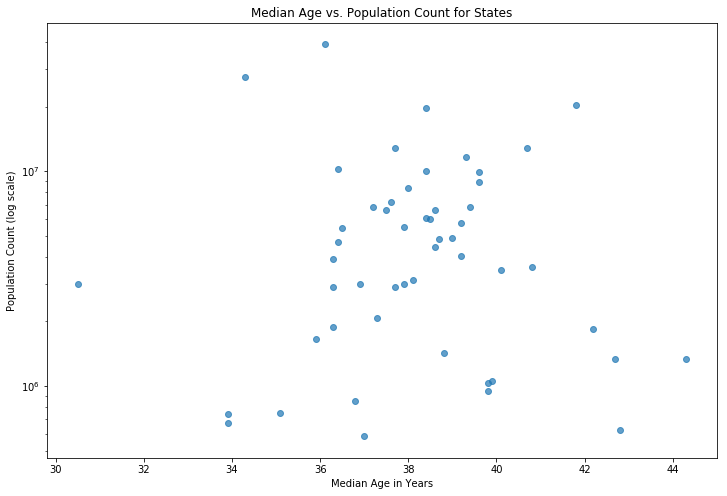

In [0]:
# Generate the plot for state data
plot_data('Median Age vs. Population Count for States', state_clean)

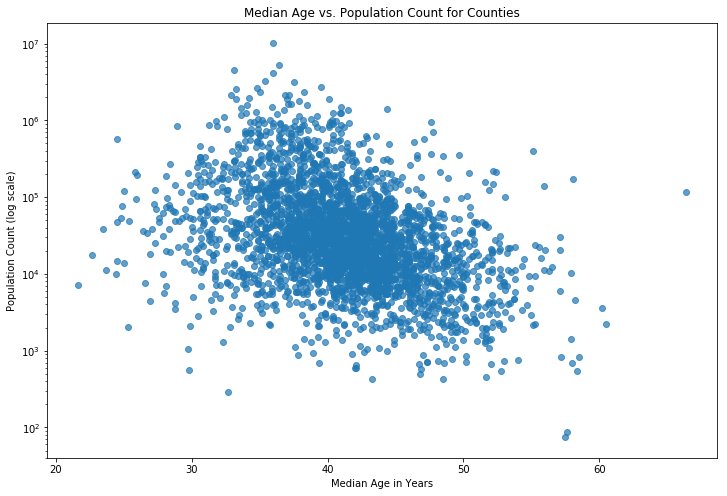

In [0]:
# Generate the plot for county data
plot_data('Median Age vs. Population Count for Counties', county_clean)

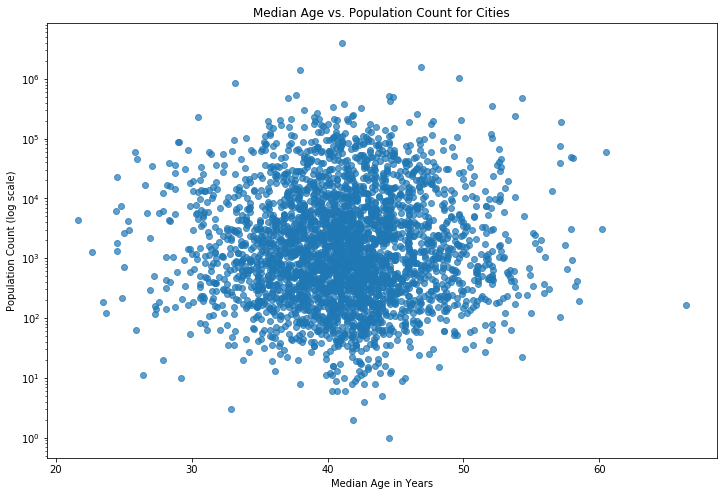

In [0]:
# Generate the plot for city data
plot_data('Median Age vs. Population Count for Cities', city_clean)

We can also plot each administrative area granularity on the same plot to see how they relate.

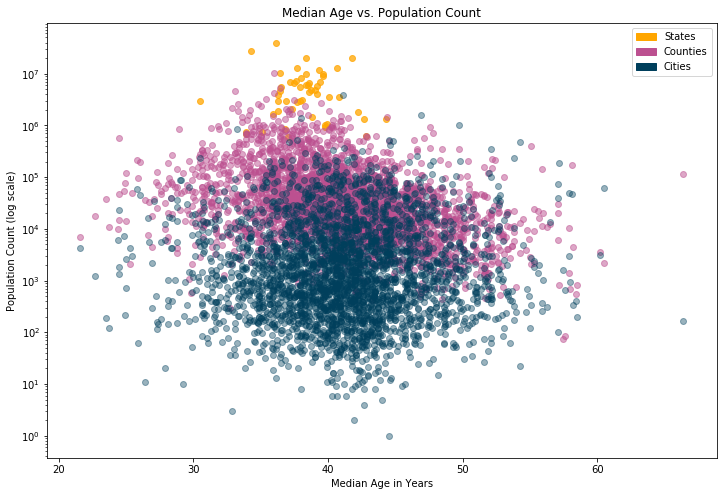

In [0]:
def plot_all_data(state_table, county_table, city_table):
  plt.figure(figsize=(12, 8))
  plt.title('Median Age vs. Population Count')
  plt.xlabel('Median Age in Years')
  plt.ylabel('Population Count (log scale)')
  
  # Make things pretty
  state_color = "#ffa600"
  county_color = "#bc5090"
  city_color = "#003f5c"
  
  # Scatter plot the information
  ax = plt.gca()
  ax.set_yscale('log')
  ax.scatter(state_table['med_age'], state_table['count'], color=state_color, alpha=0.75)
  ax.scatter(county_table['med_age'], county_table['count'], color=county_color, alpha=0.5)
  ax.scatter(city_table['med_age'], city_table['count'], color=city_color, alpha=0.4)
  
  # Create the legend
  state_patch = mpatches.Patch(color=state_color, label='States')
  county_patch = mpatches.Patch(color=county_color, label='Counties')
  city_patch = mpatches.Patch(color=city_color, label='Cities')
  plt.legend(handles=[state_patch, county_patch, city_patch])

# Plot all the data together.
plot_all_data(state_clean, county_clean, city_clean)

## What's Next

Congratulations - you've completed your first Data Commons task! Now that you have completed the tutorial, you can explore the other dataCommons notebooks to get ideas for querying and joining data from the graph.